# Compressão com perdas

 * Esse notebook tem por objetivo comparar dois tipos de compressão de imagens: JPEG e SVD. 
 * Ambos processos são compressões com perdas, conseguindo maiores taxas de compressão, porém, utilizando algoritmos distintos.
 * As métricas utilizadas para comparação e para medir a qualidade da compressão serão o RMSE(Root Mean Square Error) e o PSNR(Peak Signal-to-noise Ratio)

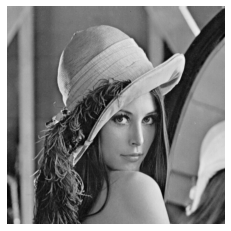

In [ ]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fftpack
import matplotlib.image as mpimg
import math

# Abrindo imagem
image_name = "lena512.pgm"
img = cv2.imread(image_name,0)
img = img.astype(float)
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.show()

# RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# PSNR
def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

In [ ]:
def fill_image(img, step):
  if img.shape[0]%step != 0:
    tmp_zeros_y = np.zeros(shape=(step - img.shape[0]%step, img.shape[1]))
    img = np.concatenate((img, tmp_zeros_y))
  if img.shape[1]%step != 0:
    tmp_zeros_x = np.zeros(shape=(img.shape[0], step - img.shape[1]%step))
    img = np.concatenate((img, tmp_zeros_x), axis = 1)
  return img

# JPEG

### Compressão

**JPEG(Joint Photographic Experts Group)** é um método que aproveita dos seguintes recursos para a compressão:

  * Codificação por transformada
  * Quantização
  * Ordenação zigue-zague
  * Codificação por entropia

DCT(Discrete Cosine Transform)
  

* Decompõe a imagem em um conjunto de coeficientes.

In [ ]:
# Quantidade de pixeis do lado da subimagem a ser processada a cada vez
step = 8

# Função para aquisição do DCT para a imagem
def get_dct(img):

    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_idct(coefficients):

    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

###Quantização

* Matriz de quantização utilizada

In [ ]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# Matriz de quantização padrão
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])


QM = QM.astype(float)

useDC = False  # encode or not DC coefficient with DCT


print ("Quantization matrix:")
print (QM)


Quantization matrix:
[[ 16.  11.  10.  16.  24.  40.  51.  61.]
 [ 12.  12.  14.  19.  26.  58.  60.  55.]
 [ 14.  13.  16.  24.  40.  57.  69.  56.]
 [ 14.  17.  22.  29.  51.  87.  80.  62.]
 [ 18.  22.  37.  56.  68. 109. 103.  77.]
 [ 24.  35.  55.  64.  81. 104. 113.  92.]
 [ 49.  64.  78.  87. 103. 121. 120. 101.]
 [ 72.  92.  95.  98. 112. 100. 103.  99.]]


## Codificação e decodificação dos números inteiros

In [ ]:
# Função que retorna o número em binário
# Números negativos sao denotados pelo complemento de 1
def entropy_encoding_number(num):
  if(num == 0): return ('', 0)
  num = int(num)
  for i in range(1,12):
    if((2**i - abs(num) > 0)):
      if(num < 0):
        return (bin(2**i - abs(num) - 1)[2:].zfill(i), i)
      else:
        return (bin(2**i - (2**i - abs(num)))[2:].zfill(i), i)

# Função que recebe uma string de 0s e 1s e retorna o inteiro correspondente da
# codificação
def entropy_decoding_number(bit_string):
  if(bit_string == ''): return 0
  binary = int(bit_string, 2)
  tmp = int(bin(2**len(bit_string)), 2)
  if(binary < tmp >> 1):
    num = tmp - binary - 1
    num = -1 * num
  else:
    num = int(bit_string, 2)
  return num

print(entropy_decoding_number('1'))
print(entropy_encoding_number(3))

1
('11', 2)


### Codificação dos coeficientes DC

* Tabela padrão para codificação dos coeficientes DC

In [ ]:
# Tabela dos coeficientes DC
dc_coef = """ 0 2 00
              1 3 010
              2 3 011
              3 3 100
              4 3 101
              5 3 110
              6 4 1110
              7 5 11110
              8 6 111110
              9 7 1111110
              10 8 11111110
              11 9 111111110"""

list1 = []
temp_list = []

for elem in dc_coef.split():
  temp_list.append(elem)
  if len(temp_list) == 3:
    list1.append(temp_list)
    temp_list = []

dc_iluminance_table = pd.DataFrame(list1)
dc_iluminance_table.columns = ["Size", "CodeLength","Code"]
dc_iluminance_table

,Size,CodeLength,Code
0,0,2,00
1,1,3,010
2,2,3,011
3,3,3,100
4,4,3,101
5,5,3,110
6,6,4,1110
7,7,5,11110
8,8,6,111110
9,9,7,1111110


* Funções para codificar os coeficientes DC utilizando DPCM(Differential Pulse Code Modulation) 

In [ ]:
def DPCM(array):

  for i in range(len(array) - 1, 0, -1):
      array[i] = array[i] - array[i-1]
  return np.array(array)


def entropy_encoding_dc_bin(dc_comp, prev):
  diff, size = entropy_encoding_number(dc_comp - prev)
  return str(dc_iluminance_table.iloc[size]["Code"]) + str(diff)


def DPCM_encoding_dc(DCcoef):
    encodedDC = ""
    DPCM_DC = DPCM(DCcoef)

    for i in range(len(DPCM_DC)):
      elem, size = entropy_encoding_number(DPCM_DC[i])
      encodedDC += str(dc_iluminance_table.iloc[size]["Code"]) + str(elem)

    return encodedDC


In [ ]:
test = np.array([9,2,4,6,6,3,7,0])
print(DPCM_encoding_dc(test))

101100110000001110011100001100100100100000


###Implementação da tabela Huffman padrão do JPEG para codificação dos coeficientes AC
* Primeiramente é necessário ler a matriz quantizada com a ordenação zigue-zague. Com seu output é possível realizar uma RLE (Run Length Encoding) que retorna o formato (x,b)num, no qual:

1. x = número de zeros antes de ler um número
2. b = número de bits necessários para codificar o número
3. num = número lido

* A tabela é utilizada por meio da tupla (x,b), gerada pelo RLE.




In [ ]:
str1 = """0,0 4 1010
0,2 2 01
0,1 2 00
0,3 3 100
0,4 4 1011
0,5 5 11010
0,6 7 1111000
0,7 8 11111000
0,8 10 1111110110
0,9 16 1111111110000010
0,10 16 1111111110000011
1,1 4 1100
1,2 5 11011
1,3 7 1111001
1,4 9 111110110
1,5 11 11111110110
1,6 16 1111111110000100
1,7 16 1111111110000101
1,8 16 1111111110000110
1,9 16 1111111110000111
1,10 16 1111111110001000
2,1 5 11100
2,2 8 11111001
2,3 10 1111110111
2,4 12 111111110100
2,5 16 1111111110001001
2,6 16 1111111110001010
2,7 16 1111111110001011
2,8 16 1111111110001100
2,9 16 1111111110001101
2,10 16 1111111110001110
3,1 6 111010
3,2 9 111110111
3,3 12 111111110101
3,4 16 1111111110001111
3,5 16 1111111110010000
3,6 16 1111111110010001
3,7 16 1111111110010010
3,8 16 1111111110010011
3,9 16 1111111110010100
3,10 16 1111111110010101
4,1 6 111011
4,2 10 1111111000
4,3 16 1111111110010110
4,4 16 1111111110010111
4,5 16 1111111110011000
4,6 16 1111111110011001
4,7 16 1111111110011010
4,8 16 1111111110011011
4,9 16 1111111110011100
4,10 16 1111111110011101
5,1 7 1111010
5,2 11 11111110111
5,3 16 1111111110011110
5,4 16 1111111110011111
5,5 16 1111111110100000
5,6 16 1111111110100001
5,7 16 1111111110100010
5,8 16 1111111110100011
5,9 16 1111111110100100
5,10 16 1111111110100101
6,1 7 1111011
6,2 12 111111110110
6,3 16 1111111110100110
6,4 16 1111111110100111
6,5 16 1111111110101000
6,6 16 1111111110101001
6,7 16 1111111110101010
6,8 16 1111111110101011
6,9 16 1111111110101100
6,10 16 1111111110101101
7,1 8 11111010
7,2 12 111111110111
7,3 16 1111111110101110
7,4 16 1111111110101111
7,5 16 1111111110110000
7,6 16 1111111110110001
7,7 16 1111111110110010
7,8 16 1111111110110011
7,9 16 1111111110110100
7,10 16 1111111110110101
8,1 9 111111000
8,2 15 111111111000000
8,3 16 1111111110110110
8,4 16 1111111110110111
8,5 16 1111111110111000
8,6 16 1111111110111001
8,7 16 1111111110111010
8,8 16 1111111110111011
8,9 16 1111111110111100
8,10 16 1111111110111101
9,1 9 111111001
9,2 16 1111111110111110
9,3 16 1111111110111111
9,4 16 1111111111000000
9,5 16 1111111111000001
9,6 16 1111111111000010
9,7 16 1111111111000011
9,8 16 1111111111000100
9,9 16 1111111111000101
9,10 16 1111111111000110
10,1 9 111111010
10,2 16 1111111111000111
10,3 16 1111111111001000
10,4 16 1111111111001001
10,5 16 1111111111001010
10,6 16 1111111111001011
10,7 16 1111111111001100
10,8 16 1111111111001101
10,9 16 1111111111001110
10,10 16 1111111111001111
11,1 10 1111111001
11,2 16 1111111111010000
11,3 16 1111111111010001
11,4 16 1111111111010010
11,5 16 1111111111010011
11,6 16 1111111111010100
11,7 16 1111111111010101
11,8 16 1111111111010110
11,9 16 1111111111010111
11,10 16 1111111111011000
12,1 10 1111111010
12,2 16 1111111111011001
12,3 16 1111111111011010
12,4 16 111111111101101
12,5 16 1111111111011100
12,6 16 1111111111011101
12,7 16 1111111111011110
12,8 16 1111111111011111
12,9 16 1111111111100000
12,10 16 1111111111100001
13,1 11 11111111000
13,2 16 1111111111100010
13,3 16 1111111111100011
13,4 16 1111111111100100
13,5 16 1111111111100101
13,6 16 1111111111100110
13,7 16 1111111111100111
13,8 16 1111111111101000
13,9 16 1111111111101001
13,10 16 1111111111101010
14,1 16 1111111111101011
14,2 16 1111111111101100
14,3 16 1111111111101101
14,4 16 1111111111101110
14,5 16 1111111111101111
14,6 16 1111111111110000
14,7 16 1111111111110001
14,8 16 1111111111110010
14,9 16 1111111111110011
14,10 16 1111111111110100
15,0 11 11111111001
15,1 16 1111111111110101
15,2 16 1111111111110110
15,3 16 1111111111110111
15,4 16 1111111111111000
15,5 16 1111111111111001
15,6 16 1111111111111010
15,7 16 1111111111111011
15,8 16 1111111111111100
15,9 16 1111111111111101
15,10 16 1111111111111110
"""

list1 = []
temp_list = []

for elem in str1.split():
  temp_list.append(elem)
  if len(temp_list) == 3:
    list1.append(temp_list)
    temp_list = []

ac_iluminance_table = pd.DataFrame(list1) 
ac_iluminance_table.columns = ["Tuple", "CodeLength","Code"]
ac_iluminance_table

,Tuple,CodeLength,Code
0,"0,0",4,1010
1,"0,2",2,01
2,"0,1",2,00
3,"0,3",3,100
4,"0,4",4,1011
...,...,...,...
157,"15,6",16,1111111111111010
158,"15,7",16,1111111111111011
159,"15,8",16,1111111111111100
160,"15,9",16,1111111111111101


###RLE (Run Length Encoding)

In [ ]:
# RLE (Run Length Encoding)

def RLE(array):

  elem_remaining = len(array)
  zeros_counter = 0
  RLE_array = []

  for elem in array:

    # contando os zeros
    if (elem == 0):
      zeros_counter += 1
    
    elif(elem != 0):
      elem_remaining -= (zeros_counter + 1)
      bits = entropy_encoding_number(elem)
      RLE_array.append((zeros_counter,bits[1], elem))
      zeros_counter = 0


    if (zeros_counter == elem_remaining):
      RLE_array.append((0,0))

  return RLE_array


def AC_encoding(array):

    # aplicando RLE no array de input
    RLE_array = RLE(array)

    # string com o AC codificado
    encoded_AC = ""

    for tupla in RLE_array:
      if (tupla != (0,0)) & (tupla[0] <= 15):
        
        string = ""
        string += str(tupla[0])
        string += ","
        string += str(tupla[1])
        pref_code = ac_iluminance_table.loc[ac_iluminance_table["Tuple"] == string]["Code"].item()
        num_code = str(entropy_encoding_number(tupla[2])[0])
        encoded_AC += str(pref_code)
        encoded_AC += str(num_code)

      else:
        encoded_AC += "1010"
        return encoded_AC
    
    return encoded_AC

In [ ]:
test = np.array([20, 0, 3, 0, -6, 0, 0, 0, 1, 0, 7, 0, 0, 0, 0 ,0])

tupla = (1,1,2)
string = ""
code = AC_encoding(test)
print(RLE(test))
print(code)





[(0, 5, 20), (1, 2, 3), (1, 3, -6), (3, 1, 1), (1, 3, 7), (0, 0)]
110101010011011111111001001111010111110011111010


In [ ]:
image_name = "lena512.pgm"
img = cv2.imread(image_name,0)
img = img.astype(float)


org_size = img.shape

filled_img = fill_image(img, step)

DCelements = np.array([])

filled_img = filled_img - 128


grande_cadeiona_de_bits = ""

rle = []

size = filled_img.shape

#adicionando tamanho da imagem à codificacao
#24 bits para as dimensoes

grande_cadeiona_de_bits += str(bin(org_size[0])[2:].zfill(12))
grande_cadeiona_de_bits += str(bin(org_size[1])[2:].zfill(12))

for y in range(0,size[0],step):
    for x in range(0,size[1],step):
        # Faz a dct do primeiro bloco de formato step x step
        dct = get_dct(filled_img[y:y+step, x:x+step])
        DC = dct[0,0]
        # Realiza a quantização pela matriz QM
        dct = np.divide(dct, QM)
        # Descretiza
        dct = dct.round()
        # Armazena a nova matriz em coddct
        coddct = dct

        dct = np.multiply(dct, QM)
        if (useDC == True):
            dct[0,0] = DC

        # organizando vetor com os DC de todos blocos
        DCelements = np.append(DCelements, round(DC))

        # Ordenando os coeficientes quantizados em zigzag
        zigzag = np.concatenate([np.diagonal(coddct[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-coddct.shape[0], coddct.shape[0])])

        # Fazendo o Run Lenght Encoding
        rle += RLE(zigzag)
        ACelements_encoded = AC_encoding(zigzag)
        grande_cadeiona_de_bits += ACelements_encoded

DCelements_encoded = DPCM_encoding_dc(DCelements)
grande_cadeiona_de_bits += DCelements_encoded
print(DCelements_encoded[:34])

1111110100000100101010011000101101


### Gerando arquivo codificado

In [ ]:
# função para gerar um arquivo codificado
def encoded_file(output_file, array):

  # escrevendo string de bits em binario
  buffer = bytearray()

  i = 0
  while i < len(array):
      buffer.append( int(array[i:i+8], 2) )
      i += 8

  output_file.write(buffer)



##############  

encoded_output = open("encoded.bin", "wb")

encoded_file(encoded_output, grande_cadeiona_de_bits)  

encoded_output.close()

## Decodificação

### Abrindo arquivo codificado

In [ ]:
# lendo arquivo e transformando-o em uma string de bits
encoded_string = "".join(f"{n:08b}" for n in open("encoded.bin", "rb").read())


#24 primeiros bits para as dimensoes da imagem
img_size = (encoded_string[0:12],encoded_string[13:24])

print(img_size)
#removendo 24 primeiros bits da string
encoded_string = encoded_string[24::]

print(encoded_string)

('001000000000', '01000000000')
11010100001100110101101010000011000110101011111000100111101001010101111011110111101010111111010100111100111000101011010101010101111010010101101010100011111101001010011010111011001111000110001111010000010101101001110110010001101110101010110011010100111001101010110100110011110011010101101000000011010101101001100111001101010000001011010010000000011100010100000000011110010001010001001101001100010011100110100011111010110100110000101001110001010011110100110001101001101100110100111110011010011100100110100111001111111101011010001101001101110110101001101100111100110100111110011110111101001100001110101111110100101001100110111001101000111001101000100000110101100010101111010010101010010000110101011011001111110100111111000110101000111011011100100011100010101011101110001100111100000010101011111100111101001010101111000001110001010101111011100111100010101011111000110101011110010101011110111101101010101111101110110101010111110001111010010101101011001101100000111000110010

### Transformando os AC em matrizes quantizadas

In [ ]:
#apenas para tuplas de 2 posicoes
def string_to_tuple(string):
  aux = ""
  tupla = [0,0]
  i = 0
  for char in string:
    
    if (i == 0):
      if(char == ','):
        tupla[i] = int(aux)
        aux = ""
        i += 1


      if(char != ','):
        aux+= char
    
    else:
      aux += char
  
  tupla[1] = int(aux)

  return tuple(tupla)

teste = "14,4"
print(string_to_tuple(teste))

(14, 4)


* Gerando o RLE

In [ ]:



aux = ""
# Checa se a imagem tem dimensões múltiplas de 8
dim1 = int(img_size[0],2)
dim2 = int(img_size[1],2)
if int(img_size[0],2)%step != 0:
  dim1 = int(img_size[0],2) + step - int(img_size[0],2)%step
if int(img_size[1],2)%step != 0:
  dim2 = int(img_size[1],2) + step - int(img_size[1],2)%step

blocks_number = (dim1 * dim2)/64

pos = 0


while (pos < len(encoded_string) and blocks_number > 0):

    aux += encoded_string[pos]

    #enquanto nao encontrar o fim de bloco
    if(aux != "1010"):
      
      #se encontrar um codigo na tabela dos AC
      if aux in ac_iluminance_table['Code'].values:

        tupla = str(ac_iluminance_table.loc[ac_iluminance_table["Code"] == aux]["Tuple"].values[0])
        tupla = string_to_tuple(tupla)

        temp = pos+1
        number = encoded_string[temp:(temp+tupla[1])]
    
        
        number = entropy_decoding_number(number)
        
        #adicionando ao vetor com rle encoding
        rle.append((tupla[0], tupla[1], number))
        
        pos += tupla[1]

        aux = ""


    #fim do bloco
    else:
      blocks_number -= 1
      rle.append((0, 0))
      aux = ""
      

    
    
    pos += 1

#OBS: a variavel pos deve ser reutilizada na decodificacao dos componentes DC    
print(pos)    
rle

176635


[(0, 5, 16.0),
 (1, 1, 1.0),
 (0, 0),
 (0, 5, 16.0),
 (0, 2, 2.0),
 (0, 1, 1.0),
 (0, 0),
 (0, 4, 14.0),
 (0, 1, 1.0),
 (0, 1, 1.0),
 (3, 1, -1.0),
 (0, 0),
 (0, 4, 13.0),
 (4, 1, 1.0),
 (0, 0),
 (0, 4, 15.0),
 (0, 2, -2.0),
 (0, 1, 1.0),
 (2, 1, 1.0),
 (1, 1, -1.0),
 (0, 0),
 (0, 5, 21.0),
 (0, 2, -2.0),
 (3, 1, -1.0),
 (0, 0),
 (0, 5, 20.0),
 (0, 2, 3.0),
 (3, 1, -1.0),
 (0, 0),
 (0, 2, 2.0),
 (0, 4, 11.0),
 (0, 1, 1.0),
 (2, 1, -1.0),
 (1, 1, -1.0),
 (5, 1, -1.0),
 (0, 1, -1.0),
 (0, 0),
 (0, 5, -17.0),
 (1, 1, 1.0),
 (0, 1, -1.0),
 (1, 2, 2.0),
 (0, 0),
 (0, 4, -12.0),
 (0, 2, -2.0),
 (0, 1, 1.0),
 (1, 1, 1.0),
 (0, 0),
 (0, 4, -11.0),
 (1, 1, 1.0),
 (2, 1, 1.0),
 (0, 0),
 (0, 4, -11.0),
 (0, 1, -1.0),
 (0, 1, 1.0),
 (0, 0),
 (0, 4, -11.0),
 (1, 1, 1.0),
 (1, 1, 1.0),
 (0, 0),
 (0, 3, -7.0),
 (0, 2, -2.0),
 (0, 0),
 (0, 2, -3.0),
 (0, 1, -1.0),
 (0, 1, -1.0),
 (2, 1, -1.0),
 (0, 0),
 (0, 1, -1.0),
 (0, 1, -1.0),
 (0, 1, 1.0),
 (2, 1, 1.0),
 (0, 1, -1.0),
 (0, 0),
 (0, 1, 1.0),
 (0,

* Transformando o RLE em um array de 64 posições

In [ ]:
def rle_to_array(rle):
    
    #todo array tera 64 posicoes
    elem_remaining = 64
    
    array = []
    
    for tuple in rle:
        
        if (tuple == (0,0)):
            #completa o resto do array com 0's
            array.extend([0]* elem_remaining)
            
            return array
            
        
        else:
            
            array.extend([0] * tuple[0])
            array.append(tuple[2])
            
            elem_remaining -= (tuple[0]+1)
    
    array = np.array(array)
    
    return array


* Transformando o array gerado na matriz quantizada

In [ ]:
def zigzag_to_matrix(zigzag):
    zeros = np.zeros((8,8))
    rows = 0
    cols = 0
    counter = 0

    while(counter < len(zigzag)):
        if((cols + rows)%2 == 0):
            while((rows >= 0) & (rows < zeros.shape[0]) & (cols >= 0) & (cols < zeros.shape[1])):
              zeros[rows][cols] = zigzag[counter]
              counter += 1
              if(cols + 1 == zeros.shape[1]):
                rows +=1 
                break
                
              if(rows == 0):
                cols += 1
                break
                
              else:
                rows -= 1
                cols += 1
                
        else:
            while((rows >= 0) & (rows < zeros.shape[0]) & (cols >= 0) & (cols < zeros.shape[1])):
              zeros[rows][cols] = zigzag[counter]
              counter +=1 
              if(rows + 1 == zeros.shape[0]):
                 cols += 1
                 break
                
              if(cols == 0):
                rows += 1
                break
                
              else:
                rows += 1
                cols -= 1

    
    return zeros

zigson = rle_to_array(rle)
print(zigzag_to_matrix(zigson))

[[16.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


### Decodificando os componentes DC

Lendo os bits restantes e transformando em um array
* O array resultante estará decodificado com DPCM 

In [ ]:
i = pos


aux = ""
DPCM = []
while (i < len(encoded_string)):
       
      aux += encoded_string[i]
      if (aux in dc_iluminance_table['Code'].values):

          if aux == '00':
            DPCM.append(0)

          else:

            num_size = int(dc_iluminance_table.loc[dc_iluminance_table["Code"] == aux]['Size'].values[0])
            
            temp = i+1
            number = encoded_string[temp:(temp + num_size)]
            number = entropy_decoding_number(number)
            DPCM.append(number)
            
            i += num_size
          aux = ""

            
      i += 1

#decodificando o DPCM

j = 1

while j < len(DPCM):
    DPCM[j] = DPCM[j] + DPCM[j-1]
    j += 1

#array com os valores dos componentes DC
DPCM

[260,
 249,
 223,
 210,
 248,
 337,
 316,
 26,
 -267,
 -191,
 -173,
 -172,
 -169,
 -107,
 -49,
 -15,
 17,
 28,
 17,
 26,
 41,
 44,
 38,
 36,
 50,
 47,
 42,
 18,
 31,
 25,
 45,
 29,
 36,
 23,
 14,
 4,
 7,
 -1,
 -54,
 -144,
 -59,
 168,
 246,
 188,
 206,
 219,
 199,
 201,
 217,
 229,
 400,
 694,
 505,
 -168,
 -80,
 -57,
 -46,
 -47,
 -31,
 -41,
 -20,
 -24,
 -62,
 60,
 228,
 235,
 223,
 208,
 271,
 333,
 279,
 -10,
 -287,
 -219,
 -180,
 -190,
 -188,
 -118,
 -55,
 -20,
 -2,
 17,
 20,
 17,
 24,
 43,
 31,
 32,
 30,
 26,
 27,
 9,
 23,
 14,
 37,
 20,
 21,
 17,
 1,
 -5,
 -10,
 -2,
 -45,
 -124,
 -151,
 90,
 231,
 228,
 239,
 245,
 219,
 211,
 205,
 201,
 220,
 605,
 694,
 88,
 -131,
 -71,
 -56,
 -55,
 -44,
 -35,
 -17,
 7,
 -244,
 -625,
 222,
 235,
 230,
 230,
 302,
 295,
 244,
 6,
 -286,
 -222,
 -174,
 -196,
 -195,
 -119,
 -62,
 -29,
 3,
 16,
 22,
 19,
 27,
 34,
 31,
 24,
 29,
 28,
 23,
 20,
 21,
 9,
 50,
 32,
 24,
 13,
 6,
 -11,
 6,
 2,
 -34,
 -93,
 -168,
 -15,
 199,
 271,
 264,
 271,
 242,
 221,

## Reconstruindo a imagem

In [ ]:
old_shape = (int(img_size[0], 2), int(img_size[1], 2))

img_new = np.zeros(shape = old_shape)
img_new = fill_image(img_new, step)

print(img_new.shape)
position = 0
aux_list = []
x = 0
y = 0
counter = 0

for tup in rle:
  aux_list.append(tup)
  if(tup == (0,0)):
    # Transformando o rle do bloco em array
    rle_array = rle_to_array(aux_list)

    # Transformando o array em uma matriz ordenando em zigzag
    aux_matrix = zigzag_to_matrix(rle_array)

    # Multiplica a matriz pela matriz QM padrão
    aux_matrix = np.multiply(aux_matrix, QM)

    # Substituindo o primeiro elemento pelo DC
    aux_matrix[0, 0] = DPCM[counter]

    # Fazendo a transformada inversa do cosseno
    aux_matrix = get_idct(aux_matrix)

    # Atribuindo a nova imagem
    img_new[y:y+step, x:x+step] = aux_matrix

    if(x == img_new.shape[1] - step & y == img_new.shape[0] - step):
      break

    x += step

    if(x == img_new.shape[1]):
      y += step
      x = 0

    aux_list = []
    counter += 1

print(counter)

img_new = img_new[:old_shape[0], :old_shape[1]]

img_new += 128

(512, 512)
4095


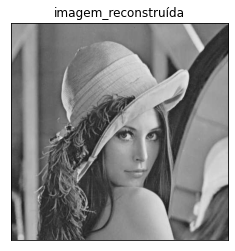

RMSE: 4.092
PSNR: 35.892
Taxa de Compressão: 75.318


In [ ]:
import os

plt.imshow(img_new, cmap = 'gray', clim=(0, 255))
plt.title('imagem_reconstruída'), plt.xticks([]), plt.yticks([])
plt.show()

print ("RMSE: %5.3f" % rmse(img, img_new))
print ("PSNR: %5.3f" % psnr(img, img_new))

# Taxa de compressão
original_image_size_bytes = img.shape[0] * img.shape[1] * img.itemsize
new_image_bin_file_size = os.path.getsize("encoded.bin")

print("Taxa de Compressão: %5.3f" % (original_image_size_bytes/new_image_bin_file_size))